# Text Prediction using Keras on Gita (Holy Book in Hinduism)

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


In [2]:
path = 'gita.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 114530


In [3]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('unique chars: ',len(chars))

unique chars:  54


In [4]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print('num training examples: ', len(sentences))

num training examples:  38164


In [5]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
sentences[100]

' mahabharata, in the sixth--or "bhishma"'

In [7]:
next_chars[100]

'-'

In [8]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False])

In [9]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [10]:
X.shape

(38164, 40, 54)

In [11]:
y.shape

(38164, 54)

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [ ]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 36255 samples, validate on 1909 samples
Epoch 1/20
36255/36255 [==============================] - 41s 1ms/step - loss: 2.5345 - acc: 0.2826 - val_loss: 2.1661 - val_acc: 0.3635
Epoch 2/20
33024/36255 [==========================>...] - ETA: 3s - loss: 2.1040 - acc: 0.3846

In [35]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [36]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

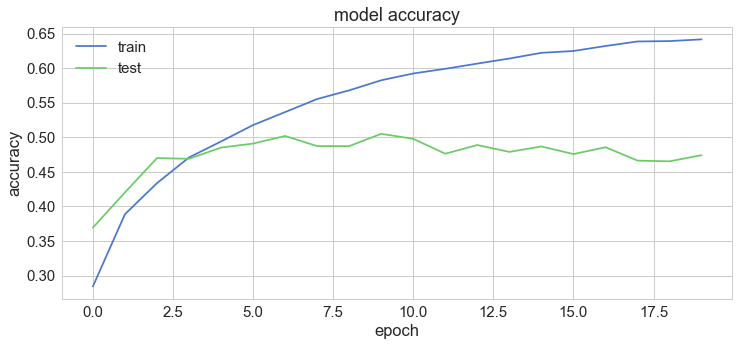

In [37]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

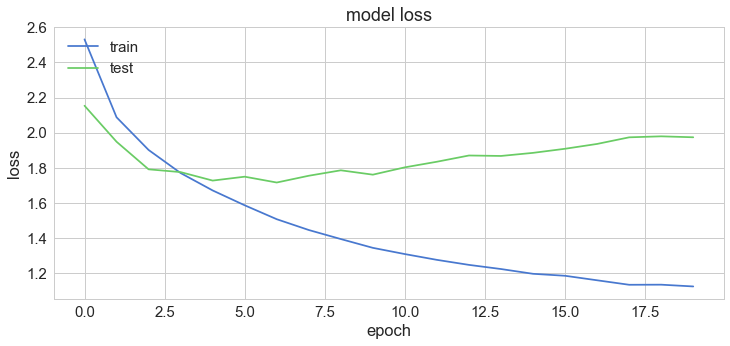

In [38]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [39]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [40]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [41]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [42]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [43]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [75]:
quotes = [
    "Scorn them that follow virtue"
]

In [76]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

scorn them that follow virtue
['tunoj""[ha:" ', 'nvyurbvbufu\nur,buyttttttouatnunu\nynrjmanjjinhcinbuumyr"byyefyubybuu]\nrummytvnnbuum\nuy\nvunuu,unu"ujstuuanbvuuuuuuuiigthmbbfmtrmrjmtttjmuuu-iyumrjjvjunubjbuyuxruurumu\nuyrbubrrvynanttutn" ', 'uumvxjmjjjjuutttjflhce ', 'i"rumbvmqvurvyj]jajtj ', 'rbbrr\numrbbffbcuuuumuumvmbfrbfbmbynunvaoantfuteyunncuuuuuuy]urjjjntouaann?uwrmbctyoj"hiubmbmuururubbuv\'xr"u"iyrbfnbmbvvruncuyucnmturvmuntwbvmntuuuurvmmvxxmtmrbmfuy\nyuyur"-ybbbyvfnyuuxu"ion-uumvmmtnajjjjq? ']



In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [3]:
print(tf.__version__)

1.8.0
